<div style="display: flex; justify-content: space-between;width:100%; height:120px;align-items: center; padding:20px; box-sizing:border-box;">
    <h1 style="margin:0;padding:0;" >PyTorch</h1>
    <img src="https://upload.wikimedia.org/wikipedia/commons/c/c6/PyTorch_logo_black.svg" 
alt="PyTorch.log" style="height:110px;margin:0;passing:0;">
</div>

## Creating a Custom Dataset for our files

In [500]:
# Image Classification
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision
from operator import getitem
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from scipy.signal import convolve2d
import numpy as np

In [265]:
img = Image.open('dog.jpg')

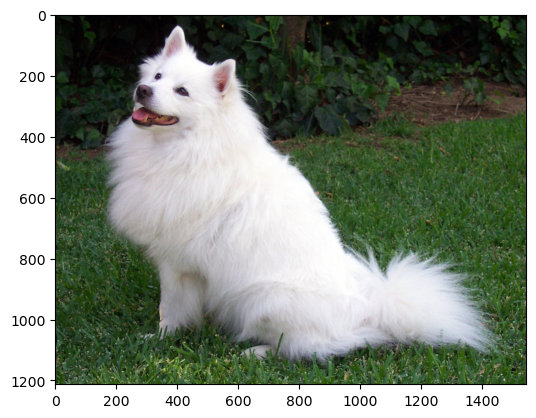

In [266]:
plt.imshow(img)

In [267]:
transforms = v2.Compose([
    # resize and then is cropped randomly
    # antialias (alias:Staircase noise along curving edges)
    v2.RandomResizedCrop(size=(1213, 1546) , antialias=True),
    # horizonltally flip the image
    v2.RandomHorizontalFlip(p=0.5),
    # Convert to Tensor
    v2.ToImage(),
    # 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.6412, 0.6687, 0.6279], std=[0.3298, 0.2905, 0.3498]),
])
img_trans = transforms(img)

The purpose of normalization is to scale the pixel values of the image in a way that makes training neural networks more efficient and effective.

**Why Normalize?**

1. *Standardizing Input for the Model*: Most models require images to be in a specific format (e.g., fixed size, tensor format, normalized pixel values). Transformations help ensure that the input is in the correct shape and format for the neural network to process

2. *Scaling pixel values*: Neural networks generally perform better when the input data is normalized (centered around 0 with a standard deviation of 1). This transformation ensures consistency in the input pixel value distribution, preventing issues like exploding/vanishing gradients and enabling faster convergence during training

3. *Improve Generalization*: Transformations such as random cropping, flipping, rotation, and color jittering are used for data augmentation. These techniques artificially expand the dataset by creating variations of the input images, helping the model generalize better and avoid overfitting.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


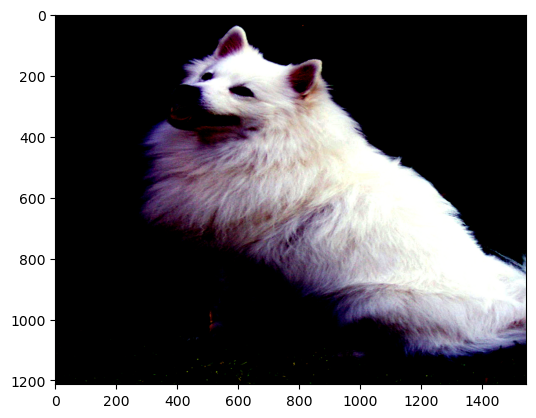

In [269]:
plt.imshow(img_trans.permute(1, 2, 0))

In [404]:
# Transformer
transformer = v2.Compose([
    v2.Resize((150, 150)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])]
        
)

 * Examples about how perform the tranformation function [Transform-PyTorch-Examples](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

In [405]:
# DataLoader
train_path = "./image/train"
test_path = "./image/val"

training_data = torchvision.datasets.ImageFolder(
    train_path, transform=transformer)
val_data = torchvision.datasets.ImageFolder(
    test_path, transform=transformer)

print("> Training Samples:", len(training_data))
print("> Val Samples:", len(val_data))

batch_size = 256
train_loader = DataLoader(
    training_data, batch_size=batch_size, shuffle=True,
)

val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=True
)

print("> Batch Size", batch_size)
print("> Training Batches:", len(train_loader))
print("> Val Batches:", len(val_loader))


> Training Samples: 14034
> Val Samples: 3000
> Batch Size 256
> Training Batches: 55
> Val Batches: 12


To see the shape of the image and its label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape: torch.Size([3, 150, 150]), Label: 2
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Text(0.5, 1.0, 'glacier')

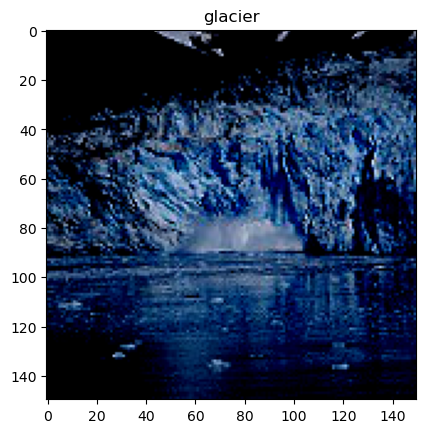

In [406]:
img, label = getitem(training_data, 5000)
print("Shape: {}, Label: {}".format(img.shape, label))
classes = training_data.classes
print("Classes: ", classes)
plt.imshow(img.permute(1, 2, 0))
plt.title(classes[label])

* https://www.youtube.com/watch?v=9OHlgDjaE2I
* https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-training.ipynb

## Convultion Neural Network
<div style = "width:100%">
    <div style = "display:flex;align-itemn:center; justify-content:center;padding:20px;border-sizing:border-box">
        <img src ="https://www.researchgate.net/publication/323747175/figure/fig1/AS:631607782293603@1527598438946/Convolutional-neural-network-LeNet-5-from-LeCun-et-al-4.png" style = "width:60%;">
    </div>
</div>


One of the advantages of the Convultion Neural Network (CNN), it can learn from *raw data*. 

For this reason, it's common to consider CNN layers as feature extractors: 
* The early layers (those right after the input layer) extract low-level features from raw data, and
* The later layers (often fully connected layers, as in a multilayer perceptron (MLP)) use these features to predict a continuous target value or class label.

Here appear the concept of **feature hieranchy**, where the the lower-level features (in the early layer) are combined to form hight level features (in the later layer).

For the case of the images, lower-level features can be the edges, and the high-level features  like cats or dogs.

### Discrete Convolutions

When the computer reads an image, this is descomposed to layers RGB(Red, Green, Blue) or RGBA. Each layer has a matrix that is the width and the height of the image.

<div class = "main">
    <div class = "blocked" style = "display:flex; align-items: center; justify-content:center">
        <img src = "./assets/doraemon.jpg" style = "width:150px;">
        <span style="display:flex; align-items: center; justify-content:center; flex-direction: column;margin:10px">
            <svg xmlns="http://www.w3.org/2000/svg" width="24" height="24" style="fill: rgba(0, 0, 0, 1)"><path d="m11.293 17.293 1.414 1.414L19.414 12l-6.707-6.707-1.414 1.414L15.586 11H6v2h9.586z"></path></svg>
            <span >Transform</span>
        </span>
        <img src = "./assets/red-green-blue.PNG">
    </div>
</div>



In [51]:
from matplotlib.image import imread
from IPython.display import Image as ImageDisplay

# read the files and convert to numpy arrays by pixel
image_map = imread(r'assets/doraemon.JPG')
image_map = image_map.astype(float) / 255.0
# base to print the image
btp = 'The image of Height: {}px, Weight: {}px is descomposed in tuple color {} (red, green, blue)'
print(btp.format(*image_map.shape))

The image of Height: 497px, Weight: 497px is descomposed in tuple color 3 (red, green, blue)


In [52]:
colors = ['red','green', 'blue']
for i, color in enumerate(colors):
    print(f"{f'Color: {color}':^30}", image_map[:,:, i], sep='\n')

          Color: red          
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
         Color: green         
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
         Color: blue          
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


Discrete Convultion is the operation performs the in CNN to learn from *raw data*.

The first concept that we have to learn is *local piece of pixels* is referred to as the **local receptive field**. This can be understanding with the gif below. For the red matrix (Input Channel red), the *local piece of pixels* would be the small red matrix of shape (3,3) that is slicing on *Input Channel red*

This *local piece of pixels* is multiplied by the `reverse` of the *kernel*. Later we will discuss about it .

We can see that in the matrix (Input Channel red) was added `zeros` around the original matrix. This process is called `padded to zeros`. The number of zeros added is a parameter `p`. It is a tuple `p = (_, _)`, the first is for adding zeros to row and the second to add at column. The most popular setting is `(1, 1)`, that is, this fill around the matrix original 1 layer of zeros.

> This operation (padded zeros) is done with the goal handle the dimentions or shape of matrix ouput called tranformed matrix or output volume.

The other parameter is called `stride` `(_, _)`. This is the number of pixeles which the matrix is *shifted* when this matrix is slicing. The first is for row and the second for the column. For the gif below `s = (1, 1)`.

The another parameter is `out_channel`. This is the volume of convultion output. It corresponds to the number of channels after apply the convultion. For the example below, we have 3 *filters or kernels* , this must match with the number of Input Channels, 3 for this case.  The *out_channel* is similar to out_node, [recall, in a MLP if we had 5 input nodes in the input layer and only one node the hidden layer, that mean we have 5 W's + 1 bias]. Here is similar, we have 3 filters or kernels, one for each color matrix (Input Channel). 

**Determining the size of the convolution output**

Let color matrix and kernel  squared (the columns and the rows are the same), the padding for the rows and columns are the same at $p$ and the shift are the same for the row and column at $s$ .

So $n$ is the lenght of the column of the color matrix, $m$ is the lenght of the column kernel or filter and, $p$ is the padding and $s$ is the shift are previouly defined.

$$o = \frac{n+2p-m}{s} + 1$$



<div align = "center">
    <img src = "./assets/process-convultion.gif" style = "width:700px;">
</div>

The results of the output convultion matrix for each color , those are add to return Output volumen. The gif above don't make the output convultion matrix convultion for each color, it skeep this step and  computing directly the output volume.

In [396]:
colors = ['red', 'green', 'blue']
Ws = {'red': np.array([[1, -1, 1], [1, 1, -1], [-1, 1, 1]]),
      'green': np.array([[-1, 1, -1], [1, -1, 1], [-1, -1, 1]]),
      'blue': np.array([[1, -1, -1], [1, 1, 1], [1, 1, -1]])}

O = np.zeros(shape=(image_map.shape[0], image_map.shape[1]))
for i, color in enumerate(colors):
    print(f"{f'Output Convultion for Color: {color}':^30}")
    print(Conv:=convolve2d(image_map[:, :, i], Ws[color], mode='same'))
    # Then we have to add each output convolution to compute th output  volume
    O += Conv

NameError: name 'image_map' is not defined

In [55]:
# thi is only for 1 depth and without bias. 
# The models usually pass more depth than 1. and the bias is added as well.
O

array([[4., 4., 4., ..., 4., 4., 0.],
       [4., 5., 5., ..., 5., 5., 2.],
       [4., 5., 5., ..., 5., 5., 2.],
       ...,
       [4., 5., 5., ..., 5., 5., 2.],
       [4., 5., 5., ..., 5., 5., 2.],
       [4., 6., 6., ..., 6., 6., 4.]])

Above pass the `mode = same`. There are other modes, this depend of the combination of `s` and `p`. The most popular is `p = s = (1, 1)`. This combination  is called `same padding`. 

### Subsampling layers

Subsampling is typically applied in two forms of pooling operations in CNNs: max-pooling and mean-pooling (also known as average-pooling). 

The pooling layer is usually denoted by $𝑃_{𝑛_2\text{x}𝑛_1}$. Here, the subscript determines the size of the neighborhood (the number of adjacent pixels in each dimension) where the max or mean operation is performed. We refer to such a neighborhood as the pooling size.

Here, *max-pooling* takes the maximum value from a neighborhood of pixels, and *mean-pooling* computes their average

<div style = "">
    <div style = "display:flex;align-items:center; justify-content:center; flex-direction:column;" >
    <img src = "./assets/pooling.png">
    <span>Sebastian Liu Yuxi </span>
    </div>
</div>


* Pooling (max-pooling) introduces a local invariance. This means that small changes in a local
neighborhood do not change the result of max-pooling.
* Pooling decreases the size of features, which results in higher computational efficiency.

For regularizing an NN we use Dropout

In [397]:
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn as nn

In [398]:
img, label = next(iter(train_loader))

In [407]:
# CNN Network

class ConvNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNet, self).__init__()
        self.stack = nn.Sequential(
            # initial input shape : (256, 3, 150, 150)
            # output shape : (256, 12, 150, 150)
            nn.Conv2d(
                in_channels=3, out_channels=12, 
                kernel_size=3, stride=1, padding=1),
            # Apply nomalization by channel (delta and beta are learning) 
            # (x - mean)/std * delta + beta
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),
            # input shape : (256, 12, 150, 150)
            # output shape : (256, 12, 75, 75)
            nn.MaxPool2d(kernel_size=2),
            # input shape : (256, 12, 150, 150)
            # output shape : (256, 20, 75, 75)
            nn.Conv2d(
                in_channels=12, out_channels=20, 
                kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # input shape : (256, 20, 150, 150)
            # output shape : (256, 32, 75, 75)
            nn.Conv2d(
                in_channels=20, out_channels=32, 
                kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

        self.fc =  nn.Linear(in_features=75 * 75 * 32,
                       out_features=num_classes)

        # Output size after convolution filter
        # ((w-f+2P)/s) +1

    def forward(self, input):
        output  = self.stack(input)
        # Above output will be in matrix form, with shape (256,32,75,75)
        output = output.view(-1, 32*75*75)
        # Resize the array. -1 a comodin to fit the dimention of the rows given
        # the dimentions of the columns, 32*75*75.
        output = self.fc(output)

        return output

As initial we have a batch of $256$ samples, in which each example is a matrix of shape $(3, 150, 150)$

*Batch Normalization* allows us to use much higher learning rates and
be less careful about initialization

In [408]:
model=ConvNet(num_classes=6)

In [409]:
#Optmizer and loss function
import torch.optim as optim

optimizer=optim.SGD(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [443]:
num_epochs = 70
#calculating the size of training and testing images
train_count=len(training_data)
val_count=len(val_data)
print(f"Training Samples: {train_count}")
print(f"Val Samples: {val_count}")

Training Samples: 14034
Val Samples: 3000


In [444]:
# Model training and saving best model

best_accuracy = 0.0

for epoch in range(num_epochs):

    # Evaluation and training on training dataset
    # print("I'm here")
    model.train()
    
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data*images.size(0)
        # The output is like [[1.2, 0.1, 0.6, 9.6, 0.1, 0.2]]
        # The want to choice the index (the class) where the value is max
        _, prediction = torch.max(outputs.data, 1)
        # Here 1 is refert the row 

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss) +
          ' Train Accuracy: '+str(train_accuracy))

Epoch: 0 Train Loss: tensor(1.0696) Train Accuracy: 0.6363118141655978
Epoch: 1 Train Loss: tensor(0.9409) Train Accuracy: 0.6708707424825424
Epoch: 2 Train Loss: tensor(0.8142) Train Accuracy: 0.7098475131822716
Epoch: 3 Train Loss: tensor(0.7424) Train Accuracy: 0.731722958529286
Epoch: 4 Train Loss: tensor(0.7414) Train Accuracy: 0.7372808892689183
Epoch: 5 Train Loss: tensor(0.6408) Train Accuracy: 0.7736212056434374
Epoch: 6 Train Loss: tensor(0.5692) Train Accuracy: 0.8034060139660824
Epoch: 7 Train Loss: tensor(0.5164) Train Accuracy: 0.821077383497221
Epoch: 8 Train Loss: tensor(0.5389) Train Accuracy: 0.8099615220179563
Epoch: 9 Train Loss: tensor(0.4744) Train Accuracy: 0.837537409149209
Epoch: 10 Train Loss: tensor(0.4584) Train Accuracy: 0.8475131822716261
Epoch: 11 Train Loss: tensor(0.4334) Train Accuracy: 0.857488955394043
Epoch: 12 Train Loss: tensor(0.4034) Train Accuracy: 0.8720963374661537
Epoch: 13 Train Loss: tensor(0.3883) Train Accuracy: 0.8788656120849366
Epoch:

In [445]:
# Evaluation on validation dataset
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.eval()

    val_accuracy = 0.0
    for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))

    val_accuracy = val_accuracy/val_count

    print('Epoch: '+str(epoch) + ' Test Accuracy: '+str(val_accuracy))

        # Save the best model
    if val_accuracy > best_accuracy:
            torch.save(model.state_dict(), 'best_checkpoint.model')
            best_accuracy = val_accuracy

Epoch: 0 Test Accuracy: 0.793
Epoch: 1 Test Accuracy: 0.7906666666666666
Epoch: 2 Test Accuracy: 0.7946666666666666
Epoch: 3 Test Accuracy: 0.7953333333333333
Epoch: 4 Test Accuracy: 0.7923333333333333
Epoch: 5 Test Accuracy: 0.7876666666666666
Epoch: 6 Test Accuracy: 0.7896666666666666
Epoch: 7 Test Accuracy: 0.788
Epoch: 8 Test Accuracy: 0.7876666666666666
Epoch: 9 Test Accuracy: 0.794
Epoch: 10 Test Accuracy: 0.7943333333333333
Epoch: 11 Test Accuracy: 0.791
Epoch: 12 Test Accuracy: 0.7913333333333333
Epoch: 13 Test Accuracy: 0.788
Epoch: 14 Test Accuracy: 0.7943333333333333
Epoch: 15 Test Accuracy: 0.792
Epoch: 16 Test Accuracy: 0.7923333333333333
Epoch: 17 Test Accuracy: 0.787
Epoch: 18 Test Accuracy: 0.7926666666666666
Epoch: 19 Test Accuracy: 0.7883333333333333
Epoch: 20 Test Accuracy: 0.7913333333333333
Epoch: 21 Test Accuracy: 0.7926666666666666
Epoch: 22 Test Accuracy: 0.7943333333333333
Epoch: 23 Test Accuracy: 0.7956666666666666
Epoch: 24 Test Accuracy: 0.7873333333333333
E

In [413]:
# checkpoint = torch.load("best_checkpoint.model")
# model = ConvNet(num_classes=6)
# model.load_state_dict(checkpoint)
# model.eval()

In [446]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    # add the batch_size dimension
    # This due to the fact the training function expects batches
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input_=Variable(image_tensor)
    
    output=model(input_)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred

In [498]:

path_pred = Path('./image/pred')
images_path=path_pred.glob('*.jpg')
pred_dict={}
# pred_dict[img.name] = prediction(next(images_path),transformer)
for idx, img in enumerate(images_path):
    pred_dict[img.name]=prediction(img,transformer)
    if idx == 11:
        break

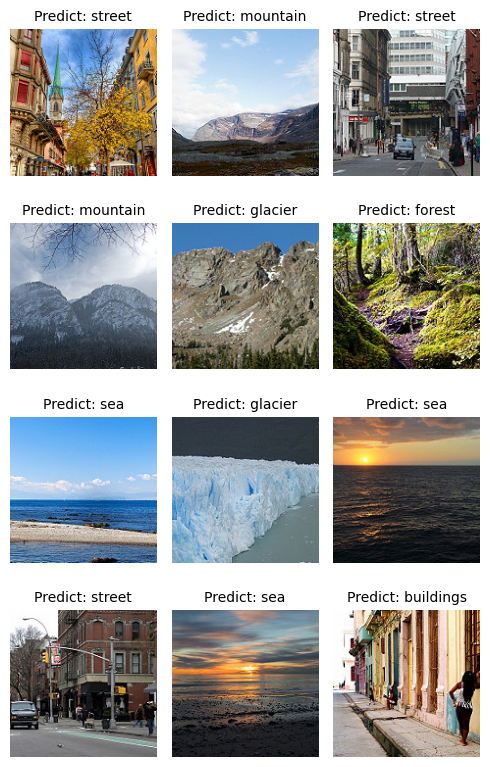

In [499]:
fig, axs = plt.subplots(4,3, figsize=(5, 8))

for idx, img_test in zip(product(range(4), range(3)),  pred_dict):
    data = plt.imread(path_pred.joinpath(img_test))
    axs[idx].imshow(data)
    axs[idx].set_title("Predict: " + pred_dict[img_test], size=10)
    axs[idx].axis("off")

fig.tight_layout()